# SRCNN을 사용하여 블러 처리된 이미지를 복원하기

사용한 데이터셋 : CelebA

### 원본 이미지와 블러 처리한 이미지를 데이터셋으로 설정

In [ ]:
#데이터셋을 설정하는 코드
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset


class TrainDataset(Dataset):
    def __init__(self, paths):
        self.paths = paths
        self.transform1 = transforms.ToTensor()
        #블러 처리
        self.transform2 = transforms.GaussianBlur(kernel_size=5, sigma=(1.0, 1.5))

    def __getitem__(self, idx):
        path = self.paths[idx]

        lab = Image.open(path)
        lab = self.transform1(lab)
        img = self.transform2(lab)

        return img, lab

    def __len__(self):
        return len(self.paths)

### Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class SRCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=2, padding_mode='replicate')
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5, padding=2, padding_mode='replicate')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)

        return x


### Train

In [ ]:
import glob
import torch
from model import SRCNN
from datasets import TrainDataset
from torch.utils.data import DataLoader
from torch import nn
from torch import optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_list = glob.glob('../datasets/train/img_align_celeba/img_align_celeba/*.jpg')

train_datasets = TrainDataset(data_list)
train_dataloader = DataLoader(train_datasets, batch_size=64)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)


model = SRCNN().to(device)
model.apply(weights_init)

loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters())
epoch = 30


def train(m, data_ld):
    m.train()
    e_loss = 0.0

    for i, (img, label) in enumerate(data_ld):
        img = img.to(device)
        label = label.to(device)

        opt.zero_grad()
        out = model(img)
        loss = loss_func(out, label)
        loss.backward()
        opt.step()

        e_loss += loss.item()

    return e_loss / len(data_ld.dataset)


loss_list = list()

for e in range(epoch):
    epoch_loss = train(model, train_dataloader)
    print(f'epoch: {e+1} and epoch loss: {epoch_loss}')
    loss_list.append(epoch_loss)

torch.save(model, 'SRCNN30.pth')

### Test

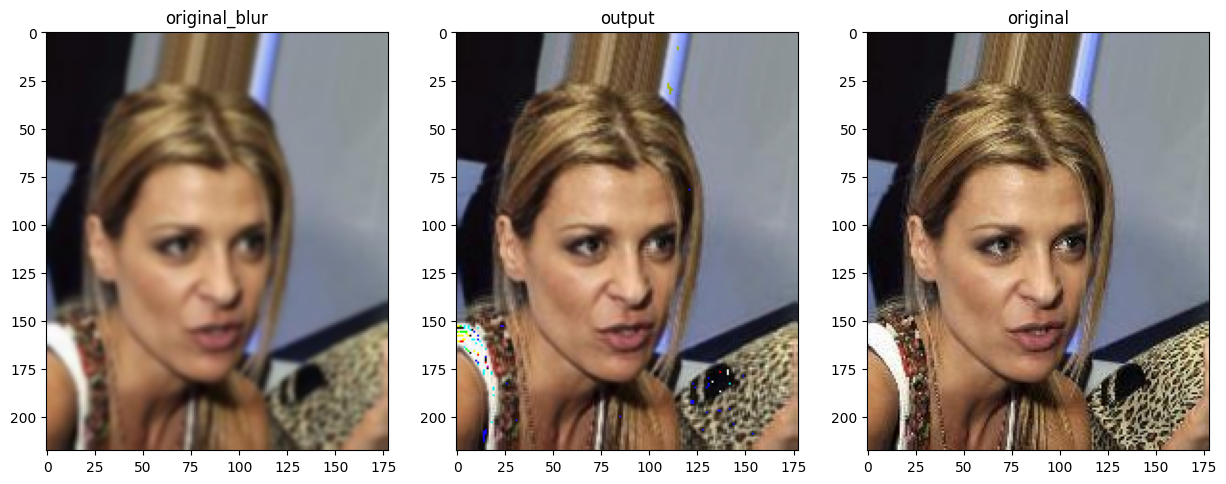

In [4]:
import torch
from torch.utils.data import DataLoader
from datasets import TrainDataset
import glob
import matplotlib.pyplot as plt
import torchvision.transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sr_model = torch.load('SRCNN30.pth', map_location=device)

data_list = glob.glob('../datasets/train/img_align_celeba/img_align_celeba/*.jpg')
test_datasets = TrainDataset(data_list)
test_dataloader = DataLoader(test_datasets, batch_size=64, shuffle=True)

for img, label in test_dataloader:
    img = img[0]
    label = label[0]
    break

sr_model.eval()
with torch.no_grad():
    img_ = img.unsqueeze(0)
    img_ = img_.to(device)
    output = sr_model(img_)
    output = output.squeeze(0)

transform = T.ToPILImage()

blur_image = transform(img)
original = transform(label)
output_tested_image = transform(output)

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(blur_image)
plt.title('original_blur')
plt.subplot(1,3,2)
plt.imshow(output_tested_image)
plt.title('output')
plt.subplot(1,3,3)
plt.imshow(original)
plt.title('original')
plt.show()